# Donors Choose - Using SGD Classifier with hinge loss

<h4><font color = "red"> Objective </font>: Predict whether teachers' project proposals are accepted</h4>



<h3> <font color="black">Importing packages</font></h3> 

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

from chart_studio import plotly
import plotly.offline as offline
import plotly.graph_objs as go
offline.init_notebook_mode()
from collections import Counter

### <h3> <font color="black">Reading the data</font></h3> 

In [2]:
project_data = pd.read_csv('train_data.csv')
resource_data = pd.read_csv('resources.csv')

<h4> <font color="gray">Project data</font></h4> 

In [3]:
print("Number of data points in train data", project_data.shape)
print('-'*50)
print("Attributes :", project_data.columns.values)
project_data.head(2)

Number of data points in train data (109248, 17)
--------------------------------------------------
Attributes : ['Unnamed: 0' 'id' 'teacher_id' 'teacher_prefix' 'school_state'
 'project_submitted_datetime' 'project_grade_category'
 'project_subject_categories' 'project_subject_subcategories'
 'project_title' 'project_essay_1' 'project_essay_2' 'project_essay_3'
 'project_essay_4' 'project_resource_summary'
 'teacher_number_of_previously_posted_projects' 'project_is_approved']


,Unnamed: 0,id,teacher_id,teacher_prefix,school_state,project_submitted_datetime,project_grade_category,project_subject_categories,project_subject_subcategories,project_title,project_essay_1,project_essay_2,project_essay_3,project_essay_4,project_resource_summary,teacher_number_of_previously_posted_projects,project_is_approved
0,160221,p253737,c90749f5d961ff158d4b4d1e7dc665fc,Mrs.,IN,2016-12-05 13:43:57,Grades PreK-2,Literacy & Language,"ESL, Literacy",Educational Support for English Learners at Home,My students are English learners that are work...,"\""The limits of your language are the limits o...",NaN,NaN,My students need opportunities to practice beg...,0,0
1,140945,p258326,897464ce9ddc600bced1151f324dd63a,Mr.,FL,2016-10-25 09:22:10,Grades 6-8,"History & Civics, Health & Sports","Civics & Government, Team Sports",Wanted: Projector for Hungry Learners,Our students arrive to our school eager to lea...,The projector we need for our school is very c...,NaN,NaN,My students need a projector to help with view...,7,1


<h4> <font color="gray">Sampling out the data points: Considering 50k Random samples</font></h4> 

In [5]:
approved_project=project_data[project_data["project_is_approved"]==1].sample(n=35000,random_state=1)
rejected_project=project_data[project_data["project_is_approved"]==0].sample(n=15000,random_state=1) 
project_data=pd.concat([approved_project,rejected_project] )

<h4> <font color="gray">Handling Missing Value in "Teacher prefix" column</font></h4> 

In [6]:
a = project_data['teacher_prefix'].mode().values

In [7]:
project_data['teacher_prefix'] = project_data['teacher_prefix'].fillna(a[0])

<h4> <font color="gray">Total number of null values in each column</font></h4> 

In [8]:
#Total number of null values in each column
project_data.isnull().sum(axis = 0)

Unnamed: 0                                          0
id                                                  0
teacher_id                                          0
teacher_prefix                                      0
school_state                                        0
project_submitted_datetime                          0
project_grade_category                              0
project_subject_categories                          0
project_subject_subcategories                       0
project_title                                       0
project_essay_1                                     0
project_essay_2                                     0
project_essay_3                                 48346
project_essay_4                                 48346
project_resource_summary                            0
teacher_number_of_previously_posted_projects        0
project_is_approved                                 0
dtype: int64

<h4> <font color="gray">Resource data</font></h4> 

In [9]:
print("Number of data points in train data", resource_data.shape)
print('-'*50)
print("Attributes: ", resource_data.columns.values)
resource_data.head(2)

Number of data points in train data (1541272, 4)
--------------------------------------------------
Attributes:  ['id' 'description' 'quantity' 'price']


,id,description,quantity,price
0,p233245,LC652 - Lakeshore Double-Space Mobile Drying Rack,1,149.00
1,p069063,Bouncy Bands for Desks (Blue support pipes),3,14.95


<h4> <font color="gray">Replacing date-time with date</font></h4> 

In [10]:
# how to replace elements in list python: https://stackoverflow.com/a/2582163/4084039
cols = ['Date' if x=='project_submitted_datetime' else x for x in list(project_data.columns)]


#sort dataframe based on time pandas python: https://stackoverflow.com/a/49702492/4084039
project_data['Date'] = pd.to_datetime(project_data['project_submitted_datetime'])
project_data.drop('project_submitted_datetime', axis=1, inplace=True)
project_data.sort_values(by=['Date'], inplace=True)


# how to reorder columns pandas python: https://stackoverflow.com/a/13148611/4084039
project_data = project_data[cols]


project_data.head(2)

,Unnamed: 0,id,teacher_id,teacher_prefix,school_state,Date,project_grade_category,project_subject_categories,project_subject_subcategories,project_title,project_essay_1,project_essay_2,project_essay_3,project_essay_4,project_resource_summary,teacher_number_of_previously_posted_projects,project_is_approved
55660,8393,p205479,2bf07ba08945e5d8b2a3f269b2b3cfe5,Mrs.,CA,2016-04-27 00:27:36,Grades PreK-2,Math & Science,"Applied Sciences, Health & Life Science",Engineering STEAM into the Primary Classroom,I have been fortunate enough to use the Fairy ...,My students come from a variety of backgrounds...,Each month I try to do several science or STEM...,It is challenging to develop high quality scie...,My students need STEM kits to learn critical s...,53,1
76127,37728,p043609,3f60494c61921b3b43ab61bdde2904df,Ms.,UT,2016-04-27 00:31:25,Grades 3-5,Special Needs,Special Needs,Sensory Tools for Focus,Imagine being 8-9 years old. You're in your th...,"Most of my students have autism, anxiety, anot...",It is tough to do more than one thing at a tim...,When my students are able to calm themselves d...,My students need Boogie Boards for quiet senso...,4,1


In [11]:
# https://matplotlib.org/gallery/pie_and_polar_charts/pie_and_donut_labels.html#sphx-glr-gallery-pie-and-polar-charts-pie-and-donut-labels-py

y_value_counts = project_data['project_is_approved'].value_counts()
print("Number of projects thar are approved for funding ", y_value_counts[1], ", (", (y_value_counts[1]/(y_value_counts[1]+y_value_counts[0]))*100,"%)")
print("Number of projects thar are not approved for funding ", y_value_counts[0], ", (", (y_value_counts[0]/(y_value_counts[1]+y_value_counts[0]))*100,"%)")


Number of projects thar are approved for funding  35000 , ( 70.0 %)
Number of projects thar are not approved for funding  15000 , ( 30.0 %)


<h4><font color='green'> NOTE: This is an imbalance dataset that containes 85% approved project's data and 15% not approved project's data</font></h4>

<h3> <font color="black">Preprocessing Categorical Data</font></h3> 

<h4> <font color="gray">Project Subject Categories</font></h4> 

In [12]:
catogories = list(project_data['project_subject_categories'].values)
# remove special characters from list of strings python: https://stackoverflow.com/a/47301924/4084039

# https://www.geeksforgeeks.org/removing-stop-words-nltk-python/
# https://stackoverflow.com/questions/23669024/how-to-strip-a-specific-word-from-a-string
# https://stackoverflow.com/questions/8270092/remove-all-whitespace-in-a-string-in-python
cat_list = []
for i in catogories:
    temp = ""
    # consider we have text like this "Math & Science, Warmth, Care & Hunger"
    for j in i.split(','): # it will split it in three parts ["Math & Science", "Warmth", "Care & Hunger"]
        if 'The' in j.split(): # this will split each of the catogory based on space "Math & Science"=> "Math","&", "Science"
            j=j.replace('The','') # if we have the words "The" we are going to replace it with ''(i.e removing 'The')
        j = j.replace(' ','') # we are placeing all the ' '(space) with ''(empty) ex:"Math & Science"=>"Math&Science"
        temp+=j.strip()+" " #" abc ".strip() will return "abc", remove the trailing spaces
        temp = temp.replace('&','_') # we are replacing the & value into 
    cat_list.append(temp.strip())
    
project_data['clean_categories'] = cat_list
project_data.drop(['project_subject_categories'], axis=1, inplace=True)

from collections import Counter
my_counter = Counter()
for word in project_data['clean_categories'].values:
    my_counter.update(word.split())

cat_dict = dict(my_counter)
sorted_cat_dict = dict(sorted(cat_dict.items(), key=lambda kv: kv[1]))

<h4> <font color="gray">Project Subject Sub-Categories</font></h4>

In [13]:
sub_catogories = list(project_data['project_subject_subcategories'].values)
# remove special characters from list of strings python: https://stackoverflow.com/a/47301924/4084039

# https://www.geeksforgeeks.org/removing-stop-words-nltk-python/
# https://stackoverflow.com/questions/23669024/how-to-strip-a-specific-word-from-a-string
# https://stackoverflow.com/questions/8270092/remove-all-whitespace-in-a-string-in-python

sub_cat_list = []
for i in sub_catogories:
    temp = ""
    # consider we have text like this "Math & Science, Warmth, Care & Hunger"
    for j in i.split(','): # it will split it in three parts ["Math & Science", "Warmth", "Care & Hunger"]
        if 'The' in j.split(): # this will split each of the catogory based on space "Math & Science"=> "Math","&", "Science"
            j=j.replace('The','') # if we have the words "The" we are going to replace it with ''(i.e removing 'The')
        j = j.replace(' ','') # we are placeing all the ' '(space) with ''(empty) ex:"Math & Science"=>"Math&Science"
        temp +=j.strip()+" "#" abc ".strip() will return "abc", remove the trailing spaces
        temp = temp.replace('&','_')
    sub_cat_list.append(temp.strip())

project_data['clean_subcategories'] = sub_cat_list
project_data.drop(['project_subject_subcategories'], axis=1, inplace=True)

# count of all the words in corpus python: https://stackoverflow.com/a/22898595/4084039
my_counter = Counter()
for word in project_data['clean_subcategories'].values:
    my_counter.update(word.split())
    
sub_cat_dict = dict(my_counter)
sorted_sub_cat_dict = dict(sorted(sub_cat_dict.items(), key=lambda kv: kv[1]))

<h3> <font color="black">Preprocessing Text Data</font></h3> 

<h4> <font color="gray">Project Essay</font></h4> 

In [14]:
# merge two column text dataframe: 
project_data["essay"] = project_data["project_essay_1"].map(str) +\
                        project_data["project_essay_2"].map(str) + \
                        project_data["project_essay_3"].map(str) + \
                        project_data["project_essay_4"].map(str)

 <h4> <font color="gray">Compound Sentiment score of Project essay</font></h4> 

In [15]:
#https://medium.com/analytics-vidhya/simplifying-social-media-sentiment-analysis-using-vader-in-python-f9e6ec6fc52f

import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

sid = SentimentIntensityAnalyzer()

essays = project_data['essay']
essays_sentiments = []

for essay in tqdm(essays):
    res = sid.polarity_scores(essay)
    essays_sentiments.append(res['compound']) #Considering compound as a criteria.

project_data['essay_sentiment'] = essays_sentiments

[nltk_data] Error loading vader_lexicon: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     self signed certificate in certificate chain
[nltk_data]     (_ssl.c:1056)>
100%|███████████████████████████████████████████████████████████████████████████| 50000/50000 [04:40<00:00, 178.38it/s]


In [16]:
# https://stackoverflow.com/a/47091490/4084039
import re


def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

<h4> <font color="gray">Word count of project essay and title</font></h4> 

In [17]:
#https://www.geeksforgeeks.org/python-program-to-count-words-in-a-sentence/
for col_type, new_col in [('project_title', 'title_size'), ('essay', 'essay_size')]:
    col_data = project_data[col_type]
    col_size = []
    for sen in col_data:
        sen = decontracted(sen)
        col_size.append(len(sen.split()))
    project_data[new_col] = col_size

In [18]:
 project_data.head(2)

,Unnamed: 0,id,teacher_id,teacher_prefix,school_state,Date,project_grade_category,project_title,project_essay_1,project_essay_2,...,project_essay_4,project_resource_summary,teacher_number_of_previously_posted_projects,project_is_approved,clean_categories,clean_subcategories,essay,essay_sentiment,title_size,essay_size
55660,8393,p205479,2bf07ba08945e5d8b2a3f269b2b3cfe5,Mrs.,CA,2016-04-27 00:27:36,Grades PreK-2,Engineering STEAM into the Primary Classroom,I have been fortunate enough to use the Fairy ...,My students come from a variety of backgrounds...,...,It is challenging to develop high quality scie...,My students need STEM kits to learn critical s...,53,1,Math_Science,AppliedSciences Health_LifeScience,I have been fortunate enough to use the Fairy ...,0.9885,6,288
76127,37728,p043609,3f60494c61921b3b43ab61bdde2904df,Ms.,UT,2016-04-27 00:31:25,Grades 3-5,Sensory Tools for Focus,Imagine being 8-9 years old. You're in your th...,"Most of my students have autism, anxiety, anot...",...,When my students are able to calm themselves d...,My students need Boogie Boards for quiet senso...,4,1,SpecialNeeds,SpecialNeeds,Imagine being 8-9 years old. You're in your th...,0.9950,4,349


In [19]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor'
stopwords= ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"]


from tqdm import tqdm
preprocessed_essays = []
# tqdm is for printing the status bar
for sentance in tqdm(project_data['essay'].values):
    sent = decontracted(sentance)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = sent.lower()
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    # https://gist.github.com/sebleier/554280
    sent = ' '.join(e for e in sent.split(" ") if e not in stopwords)
    preprocessed_essays.append(sent.lower().strip())

100%|███████████████████████████████████████████████████████████████████████████| 50000/50000 [01:02<00:00, 800.84it/s]


In [20]:
# placing the preprocessed essay into the dataframe
project_data['clean_essays'] = preprocessed_essays
project_data.drop(['essay'], axis=1, inplace=True)
project_data.drop(['project_essay_1'], axis=1, inplace=True)
project_data.drop(['project_essay_2'], axis=1, inplace=True)
project_data.drop(['project_essay_3'], axis=1, inplace=True)
project_data.drop(['project_essay_4'], axis=1, inplace=True)

In [21]:
#Printing random cleaned essay
project_data['clean_essays'].values[23]

'teach science technology 3 8 grades recently middle schoolers told would good idea real technology stem classes students since third grade seen grow physically mature emotionally students school encouraged lead example inspire creativity voice opinions actions master academics working project alone evidence desire master academics working team 2014 ten percent jobs us required stem skills hope continued support encouragement students begin see stem career option future students needed scan print park designs third term engineering project design paper park also share work others students believed access color printer scanner sharing work would easier students trying visualize work better even design something computers actually would take things home continue working printer class not extra one period stem classroom lower grades hands science classroom resources learn technology engineering need technology classroom order good stem classroom'

<h4> <font color="gray">Project title</font></h4> 

In [22]:
from tqdm import tqdm
preprocessed_titles = []
# tqdm is for printing the status bar
for sentance in tqdm(project_data['project_title'].values):
    sent = decontracted(sentance)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = sent.lower()
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    # https://gist.github.com/sebleier/554280
    sent = ' '.join(e for e in sent.split() if e not in stopwords)
    preprocessed_titles.append(sent.lower().strip())

100%|█████████████████████████████████████████████████████████████████████████| 50000/50000 [00:02<00:00, 17950.05it/s]


In [23]:
# placing the preprocessed essay into the dataframe
project_data['clean_titles'] = preprocessed_titles
project_data.drop(['project_title'], axis=1, inplace=True)

In [24]:
#Printing random cleaned title
project_data['clean_titles'].values[12]

'duct duct craft spring inspiration'

<h3> <font color="black">Merging Price and quantity data to Project data (left joining price data)</font></h3> 

In [25]:
# reference : https://stackoverflow.com/questions/22407798/how-to-reset-a-dataframes-indexes-for-all-groups-in-one-step
price_data = resource_data.groupby('id').agg({'price':'sum', 'quantity':'sum'}).reset_index()
price_data.head(2)

,id,price,quantity
0,p000001,459.56,7
1,p000002,515.89,21


In [26]:
# join two dataframes(project_data and price_data) in python
# reference : https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.merge.html
project_data = pd.merge(project_data, price_data, on='id', how='left')

<h3> <font color="black">Splitting Data and Starifying the sampling</font></h3> 

In [27]:
y = project_data['project_is_approved'].values
project_data.drop(['project_is_approved'], axis=1, inplace=True)
X = project_data

print(X.shape)
print(y.shape)

(50000, 18)
(50000,)


In [28]:
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
#https://stackoverflow.com/questions/34842405/parameter-stratify-from-method-train-test-split-scikit-learn
from sklearn.model_selection import train_test_split

# X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, shuffle=Flase)# this is for time series split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify = y) # this is random splitting
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.33, stratify = y_train) # this is random splitting

print(X_train.shape, y_train.shape)
print(X_cv.shape, y_cv.shape)
print(X_test.shape, y_test.shape)

(22445, 18) (22445,)
(11055, 18) (11055,)
(16500, 18) (16500,)


<h3> <font color="black">Vectorizing Categorical Data</font></h3> 

<h4> <font color="gray">Clean Categories</font></h4> 

In [29]:
# we use count vectorizer to convert the values into one hot encoded features

# Vectorizing "clean_categories"
from sklearn.feature_extraction.text import CountVectorizer
vectorizer_sbj = CountVectorizer(vocabulary=list(sorted_cat_dict.keys()), lowercase=False, binary=True)
vectorizer_sbj.fit(X_train['clean_categories'].values)

X_train_categories_one_hot = vectorizer_sbj.transform(X_train['clean_categories'].values)
X_cv_categories_one_hot = vectorizer_sbj.transform(X_cv['clean_categories'].values)
X_test_categories_one_hot = vectorizer_sbj.transform(X_test['clean_categories'].values)

print("After verctorizing")
print(X_train_categories_one_hot.shape, y_train.shape)
print(X_cv_categories_one_hot.shape, y_cv.shape)
print(X_test_categories_one_hot.shape, y_test.shape)

print(vectorizer_sbj.get_feature_names())

After verctorizing
(22445, 9) (22445,)
(11055, 9) (11055,)
(16500, 9) (16500,)
['Warmth', 'Care_Hunger', 'History_Civics', 'Music_Arts', 'AppliedLearning', 'SpecialNeeds', 'Health_Sports', 'Math_Science', 'Literacy_Language']


<h4> <font color="gray">Clean sub Categories</font></h4> 

In [30]:
# Vectorizing "clean_subcategories"
vectorizer_sub_sbj = CountVectorizer(vocabulary=list(sorted_sub_cat_dict.keys()), lowercase=False, binary=True)
vectorizer_sub_sbj.fit(X_train['clean_subcategories'].values)

X_train_sub_categories_one_hot = vectorizer_sub_sbj.transform(X_train['clean_subcategories'].values)
X_cv_sub_categories_one_hot = vectorizer_sub_sbj.transform(X_cv['clean_subcategories'].values)
X_test_sub_categories_one_hot = vectorizer_sub_sbj.transform(X_test['clean_subcategories'].values)

print("After verctorizing")
print(X_train_sub_categories_one_hot.shape, y_train.shape)
print(X_cv_sub_categories_one_hot.shape, y_cv.shape)
print(X_test_sub_categories_one_hot.shape, y_test.shape)

print(vectorizer_sub_sbj.get_feature_names())

After verctorizing
(22445, 30) (22445,)
(11055, 30) (11055,)
(16500, 30) (16500,)
['Economics', 'CommunityService', 'FinancialLiteracy', 'ParentInvolvement', 'Civics_Government', 'Extracurricular', 'ForeignLanguages', 'Warmth', 'Care_Hunger', 'NutritionEducation', 'SocialSciences', 'PerformingArts', 'CharacterEducation', 'TeamSports', 'Other', 'College_CareerPrep', 'Music', 'History_Geography', 'EarlyDevelopment', 'ESL', 'Health_LifeScience', 'Gym_Fitness', 'EnvironmentalScience', 'VisualArts', 'Health_Wellness', 'AppliedSciences', 'SpecialNeeds', 'Literature_Writing', 'Mathematics', 'Literacy']


<h4> <font color="gray">Teacher Prefix</font></h4> 

In [31]:
# Vectorizing "teacher_prefix"
prefix = list(set(X_train['teacher_prefix'].values))

vectorizer_teacher = CountVectorizer(vocabulary=prefix, lowercase=False, binary=True)
vectorizer_teacher.fit(X_train['teacher_prefix'].values)

X_train_prefix_one_hot = vectorizer_teacher.transform(X_train['teacher_prefix'])
X_cv_prefix_one_hot = vectorizer_teacher.transform(X_cv['teacher_prefix'])
X_test_prefix_one_hot = vectorizer_teacher.transform(X_test['teacher_prefix'])

print("After verctorizing")
print(X_train_prefix_one_hot.shape, y_train.shape)
print(X_cv_prefix_one_hot.shape, y_cv.shape)
print(X_test_prefix_one_hot.shape, y_test.shape)

print(vectorizer_teacher.get_feature_names())

After verctorizing
(22445, 5) (22445,)
(11055, 5) (11055,)
(16500, 5) (16500,)
['Mrs.', 'Teacher', 'Mr.', 'Ms.', 'Dr.']


<h4> <font color="gray">school state</font></h4> 

In [32]:
# Vectorizing "school_state"
from collections import Counter
my_counter = Counter()
for word in X_train['school_state'].values:
    my_counter.update(word.split())
    
state_dict = dict(my_counter)
sorted_state_dict = dict(sorted(state_dict.items(), key=lambda kv: kv[1]))

vectorizer_state = CountVectorizer(vocabulary=list(sorted_state_dict.keys()), lowercase=False, binary=True)
vectorizer_state.fit(X_train['school_state'].values)

X_train_state_one_hot = vectorizer_state.transform(X_train['school_state'].values)
X_cv_state_one_hot = vectorizer_state.transform(X_cv['school_state'].values)
X_test_state_one_hot = vectorizer_state.transform(X_test['school_state'].values)

print("After verctorizing")
print(X_train_state_one_hot.shape, y_train.shape)
print(X_cv_state_one_hot.shape, y_cv.shape)
print(X_test_state_one_hot.shape, y_test.shape)

print(vectorizer_state.get_feature_names())

After verctorizing
(22445, 51) (22445,)
(11055, 51) (11055,)
(16500, 51) (16500,)
['WY', 'VT', 'ND', 'SD', 'RI', 'MT', 'NE', 'NH', 'DE', 'AK', 'ME', 'WV', 'HI', 'NM', 'DC', 'IA', 'KS', 'ID', 'CO', 'AR', 'MN', 'OR', 'NV', 'KY', 'MS', 'AL', 'MD', 'TN', 'CT', 'UT', 'WI', 'AZ', 'VA', 'NJ', 'WA', 'OK', 'OH', 'MO', 'MA', 'LA', 'IN', 'MI', 'PA', 'SC', 'GA', 'IL', 'NC', 'FL', 'NY', 'TX', 'CA']


<h4> <font color="gray">Project Grade Category</font></h4> 

In [33]:
# Vectorizing "project_grade_category"
prefix = list(set(X_train["project_grade_category"].values))

vectorizer_grade = CountVectorizer(vocabulary=prefix, lowercase=False, binary=True)
vectorizer_grade.fit(X_train['project_grade_category'])

X_train_grade_one_hot = vectorizer_grade.transform(X_train['project_grade_category'])
X_cv_grade_one_hot = vectorizer_grade.transform(X_cv['project_grade_category'])
X_test_grade_one_hot = vectorizer_grade.transform(X_test['project_grade_category'])

print("After verctorizing")
print(X_train_grade_one_hot.shape, y_train.shape)
print(X_cv_grade_one_hot.shape, y_cv.shape)
print(X_test_grade_one_hot.shape, y_test.shape)

print(vectorizer_grade.get_feature_names())

After verctorizing
(22445, 4) (22445,)
(11055, 4) (11055,)
(16500, 4) (16500,)
['Grades 6-8', 'Grades 9-12', 'Grades 3-5', 'Grades PreK-2']


<h3> <font color="black">Normalizing Numerical values</font></h3> 

<h4> <font color="gray">Number of previously posted assignments by Teacher</font></h4> 

In [34]:
#https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Normalizer.html
from sklearn.preprocessing import Normalizer
normalizer = Normalizer()

normalizer.fit(X_train['teacher_number_of_previously_posted_projects'].values.reshape(1,-1))

number_projects_train = normalizer.transform(X_train['teacher_number_of_previously_posted_projects'].values.reshape(1,-1))
number_projects_cv = normalizer.transform(X_cv['teacher_number_of_previously_posted_projects'].values.reshape(1,-1))
number_projects_test = normalizer.transform(X_test['teacher_number_of_previously_posted_projects'].values.reshape(1,-1))

print("After vectorizations")
print(number_projects_train.shape, y_train.shape)
print(number_projects_cv.shape, y_cv.shape)
print(number_projects_test.shape, y_test.shape)

After vectorizations
(1, 22445) (22445,)
(1, 11055) (11055,)
(1, 16500) (16500,)


In [35]:
number_projects_train

array([[0.        , 0.        , 0.00357224, ..., 0.00071445, 0.00142889,
        0.        ]])

In [36]:
number_projects_train = np.reshape(number_projects_train, (-1, 1))
number_projects_cv = np.reshape(number_projects_cv, (-1, 1))
number_projects_test = np.reshape(number_projects_test, (-1, 1))

<h4> <font color="gray">Price</font></h4> 

In [37]:
#https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Normalizer.html
from sklearn.preprocessing import Normalizer
normalizer = Normalizer()

normalizer.fit(X_train['price'].values.reshape(1,-1))

price_train = normalizer.transform(X_train['price'].values.reshape(1,-1))
price_cv = normalizer.transform(X_cv['price'].values.reshape(1,-1))
price_test = normalizer.transform(X_test['price'].values.reshape(1,-1))

print("After vectorizations")
print(price_train.shape, y_train.shape)
print(price_cv.shape, y_cv.shape)
print(price_test.shape, y_test.shape)

After vectorizations
(1, 22445) (22445,)
(1, 11055) (11055,)
(1, 16500) (16500,)


In [38]:
price_train

array([[0.00700088, 0.0013403 , 0.00522195, ..., 0.00353458, 0.00247662,
        0.00438217]])

In [39]:
price_train=np.reshape(price_train, (-1, 1))
price_cv=np.reshape(price_cv, (-1, 1))
price_test=np.reshape(price_test, (-1, 1))

<h4> <font color="gray">Resource quantity</font></h4> 

In [40]:
#https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Normalizer.html
from sklearn.preprocessing import Normalizer
normalizer = Normalizer()

normalizer.fit(X_train['quantity'].values.reshape(1,-1))

quantity_train = normalizer.transform(X_train['quantity'].values.reshape(1,-1))
quantity_cv = normalizer.transform(X_cv['quantity'].values.reshape(1,-1))
quantity_test = normalizer.transform(X_test['quantity'].values.reshape(1,-1))

print("After vectorizations")
print(quantity_train.shape, y_train.shape) 
print(quantity_cv.shape, y_cv.shape)
print(quantity_test.shape, y_test.shape)

After vectorizations
(1, 22445) (22445,)
(1, 11055) (11055,)
(1, 16500) (16500,)


In [41]:
quantity_train 

array([[0.00020764, 0.00145346, 0.00456802, ..., 0.00083055, 0.0033222 ,
        0.02927687]])

In [42]:
quantity_train =np.reshape(quantity_train, (-1, 1))
quantity_cv =np.reshape(quantity_cv, (-1, 1))
quantity_test =np.reshape(quantity_test, (-1, 1))

<h4> <font color="gray">Sentiment score</font></h4> 

In [43]:
#https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Normalizer.html

essay_sentiment_train = X_train['essay_sentiment'].values.reshape(1,-1)
essay_sentiment_cv = X_cv['essay_sentiment'].values.reshape(1,-1)
essay_sentiment_test = X_test['essay_sentiment'].values.reshape(1,-1)

essay_sentiment_train = np.reshape(essay_sentiment_train, (-1, 1))
essay_sentiment_cv = np.reshape(essay_sentiment_cv, (-1, 1))
essay_sentiment_test = np.reshape(essay_sentiment_test, (-1, 1))

print(essay_sentiment_train.shape,y_train.shape)
print(essay_sentiment_cv.shape ,y_cv.shape)
print(essay_sentiment_test.shape,  y_test.shape)


(22445, 1) (22445,)
(11055, 1) (11055,)
(16500, 1) (16500,)


<h4> <font color="gray">Number of words in Project title</font></h4> 

In [44]:
#https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Normalizer.html
from sklearn.preprocessing import Normalizer
normalizer = Normalizer()

normalizer.fit(X_train['title_size'].values.reshape(1,-1))

title_size_train = normalizer.transform(X_train['title_size'].values.reshape(1,-1))
title_size_cv = normalizer.transform(X_cv['title_size'].values.reshape(1,-1))
title_size_test = normalizer.transform(X_test['title_size'].values.reshape(1,-1))

print("After normalization")
print(title_size_train.shape, y_train.shape)
print(title_size_cv.shape, y_cv.shape)
print(title_size_test.shape, y_test.shape)

After normalization
(1, 22445) (22445,)
(1, 11055) (11055,)
(1, 16500) (16500,)


In [45]:
title_size_train =np.reshape(title_size_train, (-1, 1))
title_size_cv =np.reshape(title_size_cv, (-1, 1))
title_size_test =np.reshape(title_size_test, (-1, 1))

print(title_size_train.shape, y_train.shape)
print(title_size_cv.shape, y_cv.shape)
print(title_size_test.shape, y_test.shape)

(22445, 1) (22445,)
(11055, 1) (11055,)
(16500, 1) (16500,)


<h4> <font color="gray">Number of words in combined Essay</font></h4> 

In [46]:
#https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Normalizer.html
from sklearn.preprocessing import Normalizer
normalizer = Normalizer()

normalizer.fit(X_train['essay_size'].values.reshape(1,-1))

essay_size_train = normalizer.transform(X_train['essay_size'].values.reshape(1,-1))
essay_size_cv = normalizer.transform(X_cv['essay_size'].values.reshape(1,-1))
essay_size_test = normalizer.transform(X_test['essay_size'].values.reshape(1,-1))

essay_size_train =np.reshape(essay_size_train, (-1, 1))
essay_size_cv =np.reshape(essay_size_cv, (-1, 1))
essay_size_test =np.reshape(essay_size_test, (-1, 1))


print(essay_size_train.shape, y_train.shape)
print(essay_size_cv.shape, y_cv.shape)
print(essay_size_test.shape, y_test.shape)

(22445, 1) (22445,)
(11055, 1) (11055,)
(16500, 1) (16500,)


<h3> <font color="black">Text Vectorization: Making data ready for models</font></h3> 

<h4> <font color="gray">BoW on Clean Essay</font></h4> 

In [47]:
# We are considering only the words which appeared in at least 10 documents(rows or projects).
vectorizer_bow_essay = CountVectorizer(min_df=10)
vectorizer_bow_essay.fit(X_train['clean_essays'].values)

X_train_essay_bow = vectorizer_bow_essay.transform(X_train['clean_essays'].values)
X_cv_essay_bow = vectorizer_bow_essay.transform(X_cv['clean_essays'].values)
X_test_essay_bow = vectorizer_bow_essay.transform(X_test['clean_essays'].values)

print("After vectorizing")
print(X_train_essay_bow.shape, y_train.shape)
print(X_cv_essay_bow.shape, y_cv.shape)
print(X_test_essay_bow.shape, y_test.shape)

After vectorizing
(22445, 8723) (22445,)
(11055, 8723) (11055,)
(16500, 8723) (16500,)


<h4> <font color="gray">BoW on Clean Title</font></h4> 

In [48]:
vectorizer_bow_title = CountVectorizer(min_df=10)
vectorizer_bow_title.fit(X_train['clean_titles'].values)

X_train_titles_bow = vectorizer_bow_title.transform(X_train['clean_titles'].values)
X_cv_titles_bow = vectorizer_bow_title.transform(X_cv['clean_titles'].values)
X_test_titles_bow = vectorizer_bow_title.transform(X_test['clean_titles'].values)

print("After vectorizing")
print(X_train_titles_bow.shape, y_train.shape)
print(X_cv_titles_bow.shape, y_cv.shape)
print(X_test_titles_bow.shape, y_test.shape)

After vectorizing
(22445, 1150) (22445,)
(11055, 1150) (11055,)
(16500, 1150) (16500,)


<h4> <font color="gray">Tfidf on Clean Essay</font></h4> 

In [49]:
from sklearn.feature_extraction.text import TfidfVectorizer


vectorizer_tfidf_essay = TfidfVectorizer(min_df=10)
vectorizer_tfidf_essay.fit(X_train['clean_essays'].values)

X_train_essay_tfidf = vectorizer_tfidf_essay.transform(X_train['clean_essays'])
X_cv_essay_tfidf = vectorizer_tfidf_essay.transform(X_cv['clean_essays'])
X_test_essay_tfidf = vectorizer_tfidf_essay.transform(X_test['clean_essays'])

print("After vectorizing")
print(X_train_essay_tfidf.shape, y_train.shape)
print(X_cv_essay_tfidf.shape, y_cv.shape)
print(X_test_essay_tfidf.shape, y_test.shape)

After vectorizing
(22445, 8723) (22445,)
(11055, 8723) (11055,)
(16500, 8723) (16500,)


<h4> <font color="gray">Tfidf on Clean Title</font></h4> 

In [50]:
vectorizer_tfidf_title = TfidfVectorizer(min_df=10)
vectorizer_tfidf_title.fit(X_train['clean_titles'].values)

X_train_title_tfidf = vectorizer_tfidf_title.transform(X_train['clean_titles'])
X_cv_title_tfidf = vectorizer_tfidf_title.transform(X_cv['clean_titles'])
X_test_title_tfidf = vectorizer_tfidf_title.transform(X_test['clean_titles'])

print("After vectorizing")
print(X_train_title_tfidf.shape, y_train.shape)
print(X_cv_title_tfidf.shape, y_cv.shape)
print(X_test_title_tfidf.shape, y_test.shape)

After vectorizing
(22445, 1150) (22445,)
(11055, 1150) (11055,)
(16500, 1150) (16500,)


<h4> <font color="gray">Avg W2V on Clean Essay</font></h4> 

In [51]:
def loadGloveModel(gloveFile):
    print ("Loading Glove Model")
    f = open(gloveFile,'r', encoding="utf8")
    model = {}
    for line in tqdm(f):
        splitLine = line.split()
        word = splitLine[0]
        embedding = np.array([float(val) for val in splitLine[1:]])
        model[word] = embedding
    print ("Done.",len(model)," words loaded!")
    return model
model = loadGloveModel('glove.42B.300d.txt')


words = []
for i in preprocessed_essays:
    words.extend(i.split(' '))

for i in preprocessed_titles:
    words.extend(i.split(' '))
print("all the words in the coupus", len(words))
words = set(words)
print("the unique words in the coupus", len(words))

inter_words = set(model.keys()).intersection(words)
print("The number of words that are present in both glove vectors and our coupus", \
      len(inter_words),"(",np.round(len(inter_words)/len(words)*100,3),"%)")

words_courpus = {}
words_glove = set(model.keys())
for i in words:
    if i in words_glove:
        words_courpus[i] = model[i]
print("word 2 vec length", len(words_courpus))


# stronging variables into pickle files python: http://www.jessicayung.com/how-to-use-pickle-to-save-and-load-variables-in-python/

import pickle
with open('glove_vectors', 'wb') as f:
    pickle.dump(words_courpus, f)
    
# stronging variables into pickle files python: http://www.jessicayung.com/how-to-use-pickle-to-save-and-load-variables-in-python/
# make sure you have the glove_vectors file
with open('glove_vectors', 'rb') as f:
    model = pickle.load(f)
    glove_words =  set(model.keys())

Loading Glove Model


1917495it [09:18, 3430.49it/s]


Done. 1917495  words loaded!
all the words in the coupus 7030520
the unique words in the coupus 43523
The number of words that are present in both glove vectors and our coupus 39639 ( 91.076 %)
word 2 vec length 39639


In [52]:
train_essay_avg_w2v = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_train['clean_essays']): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if word in words_glove:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    train_essay_avg_w2v.append(vector)

print(len(train_essay_avg_w2v))
print(len(train_essay_avg_w2v[0]))


cv_essay_avg_w2v = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_cv['clean_essays']): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if word in words_glove:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    cv_essay_avg_w2v.append(vector)

print(len(cv_essay_avg_w2v))
print(len(cv_essay_avg_w2v[0]))


test_essay_avg_w2v = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_test['clean_essays']): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if word in words_glove:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    test_essay_avg_w2v.append(vector)

print(len(test_essay_avg_w2v))
print(len(test_essay_avg_w2v[0]))

100%|██████████████████████████████████████████████████████████████████████████| 22445/22445 [00:17<00:00, 1273.17it/s]


22445
300


100%|██████████████████████████████████████████████████████████████████████████| 11055/11055 [00:06<00:00, 1591.71it/s]


11055
300


100%|██████████████████████████████████████████████████████████████████████████| 16500/16500 [00:10<00:00, 1596.10it/s]


16500
300


In [53]:
# Changing list to numpy arrays
train_essay_avg_w2v = np.array(train_essay_avg_w2v)
cv_essay_avg_w2v = np.array(cv_essay_avg_w2v)
test_essay_avg_w2v = np.array(test_essay_avg_w2v)

<h4> <font color="gray">Avg W2V on Clean Title</font></h4> 

In [54]:
train_title_avg_w2v = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_train['clean_titles']): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    train_title_avg_w2v.append(vector)

print(len(train_title_avg_w2v))
print(len(train_title_avg_w2v[0]))


cv_title_avg_w2v = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_cv['clean_titles']): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    cv_title_avg_w2v.append(vector)

print(len(cv_title_avg_w2v))
print(len(cv_title_avg_w2v[0]))


test_title_avg_w2v = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_test['clean_titles']): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    test_title_avg_w2v.append(vector)

print(len(test_title_avg_w2v))
print(len(test_title_avg_w2v[0]))

100%|█████████████████████████████████████████████████████████████████████████| 22445/22445 [00:00<00:00, 29415.06it/s]


22445
300


100%|█████████████████████████████████████████████████████████████████████████| 11055/11055 [00:00<00:00, 30225.26it/s]


11055
300


100%|█████████████████████████████████████████████████████████████████████████| 16500/16500 [00:00<00:00, 28742.81it/s]


16500
300


In [55]:
# Changing list to numpy arrays
train_title_avg_w2v = np.array(train_title_avg_w2v)
cv_title_avg_w2v = np.array(cv_title_avg_w2v)
test_title_avg_w2v = np.array(test_title_avg_w2v)

<h4> <font color="gray">Tfidf W2V on Clean essay</font></h4> 

In [56]:
tfidf_model = TfidfVectorizer()
tfidf_model.fit(X_train['clean_essays'])
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
tfidf_words = set(tfidf_model.get_feature_names())

In [57]:
train_essay_tfidf_w2v = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_train['clean_essays']): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    train_essay_tfidf_w2v.append(vector)

print(len(train_essay_tfidf_w2v))
print(len(train_essay_tfidf_w2v[0]))


cv_essay_tfidf_w2v = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_cv['clean_essays']): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    cv_essay_tfidf_w2v.append(vector)

print(len(cv_essay_tfidf_w2v))
print(len(cv_essay_tfidf_w2v[0]))


test_essay_tfidf_w2v = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_test['clean_essays']): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    test_essay_tfidf_w2v.append(vector)

print(len(test_essay_tfidf_w2v))
print(len(test_essay_tfidf_w2v[0]))

100%|███████████████████████████████████████████████████████████████████████████| 22445/22445 [01:34<00:00, 236.80it/s]


22445
300


100%|███████████████████████████████████████████████████████████████████████████| 11055/11055 [00:45<00:00, 242.48it/s]


11055
300


100%|███████████████████████████████████████████████████████████████████████████| 16500/16500 [01:06<00:00, 247.91it/s]


16500
300


In [58]:
# Changing list to numpy arrays
train_essay_tfidf_w2v = np.array(train_essay_tfidf_w2v)
cv_essay_tfidf_w2v = np.array(cv_essay_tfidf_w2v)
test_essay_tfidf_w2v = np.array(test_essay_tfidf_w2v)

<h4> <font color="gray">Tfidf W2V on Clean Title</font></h4> 

In [59]:
train_title_tfidf_w2v = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_train['clean_titles']): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    train_title_tfidf_w2v.append(vector)

print(len(train_title_tfidf_w2v))
print(len(train_title_tfidf_w2v[0]))


cv_title_tfidf_w2v = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_cv['clean_titles']): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    cv_title_tfidf_w2v.append(vector)

print(len(cv_title_tfidf_w2v))
print(len(cv_title_tfidf_w2v[0]))



test_title_tfidf_w2v = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_test['clean_titles']): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    test_title_tfidf_w2v.append(vector)

print(len(test_title_tfidf_w2v))
print(len(test_title_tfidf_w2v[0]))

100%|█████████████████████████████████████████████████████████████████████████| 22445/22445 [00:01<00:00, 17376.94it/s]


22445
300


100%|█████████████████████████████████████████████████████████████████████████| 11055/11055 [00:00<00:00, 14402.80it/s]


11055
300


100%|█████████████████████████████████████████████████████████████████████████| 16500/16500 [00:01<00:00, 15657.36it/s]


16500
300


In [60]:
# Changing list to numpy arrays
train_title_tfidf_w2v = np.array(train_title_tfidf_w2v)
cv_title_tfidf_w2v = np.array(cv_title_tfidf_w2v)
test_title_tfidf_w2v = np.array(test_title_tfidf_w2v)

<h2><font color="red">Applying SGD with Hinge loss || Linear Support vector machine</font></h2>

<h3> <font color="black">Set 1: categorical, numerical features + project_title(BOW) + preprocessed_eassay(BOW)
    </font></h3>

<h4> <font color="gray">Hstacking features</font></h4> 

In [61]:
# merge two sparse matrices: https://stackoverflow.com/a/19710648/4084039
from scipy.sparse import hstack
# with the same hstack function we are concatinating a sparse matrix and a dense matirx :)+++
X_train_bow = hstack((X_train_categories_one_hot, X_train_sub_categories_one_hot, X_train_essay_bow, quantity_train, X_train_state_one_hot, X_train_prefix_one_hot, X_train_grade_one_hot, X_train_titles_bow, price_train, number_projects_train)).tocsr()
X_cv_bow = hstack((X_cv_categories_one_hot, X_cv_sub_categories_one_hot, X_cv_essay_bow, quantity_cv, X_cv_state_one_hot, X_cv_prefix_one_hot, X_cv_grade_one_hot, X_cv_titles_bow, price_cv, number_projects_cv)).tocsr()
X_test_bow = hstack((X_test_categories_one_hot, X_test_sub_categories_one_hot, X_test_essay_bow, quantity_test, X_test_state_one_hot, X_test_prefix_one_hot, X_test_grade_one_hot, X_test_titles_bow, price_test, number_projects_test)).tocsr()

print('Final matrix')
print(X_train_bow.shape, y_train.shape)
print(X_cv_bow.shape, y_cv.shape)
print(X_test_bow.shape, y_test.shape)

Final matrix
(22445, 9975) (22445,)
(11055, 9975) (11055,)
(16500, 9975) (16500,)


<h4> <font color="gray">Hyperparameter tuning using simple for loop</font></h4> 

In [62]:
#https://datascience.stackexchange.com/questions/22762/understanding-predict-proba-from-multioutputclassifier
def batch_predict(clf, data):
    y_data_pred = []
    tr_loop = data.shape[0] - data.shape[0]%1000  #Iter untill last 1000 multiplier
    for i in range(0, tr_loop, 1000):
        y_data_pred.extend(clf.predict_proba(data[i:i+1000])[:,1])
    # we will be predicting for the last data points
    y_data_pred.extend(clf.predict_proba(data[tr_loop:])[:,1])
    
    return y_data_pred

In [63]:
#https://scikit-learn.org/stable/modules/generated/sklearn.calibration.CalibratedClassifierCV.html
from sklearn.linear_model import SGDClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
import math
from sklearn.calibration import CalibratedClassifierCV

train_auc = []
cv_auc = []
log_alphas = []


alphas = [0.0001, 0.0005, 0.001,0.005, 0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.5, 1.0, 1.5, 2.0, 2.5, 5, 10, 20, 50, 100, 500,1000,10000]  #Taking random values of alpha

for i in (alphas):
    sgd_bow = SGDClassifier(alpha=i, loss='hinge', penalty='l2',class_weight='balanced',tol=0.001)
    cal_bow = CalibratedClassifierCV(sgd_bow, method='sigmoid', cv=5)
    cal_bow.fit(X_train_bow, y_train)
 

    y_train_pred = batch_predict(cal_bow, X_train_bow )    
    y_cv_pred = batch_predict(cal_bow, X_cv_bow)
    

    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs        
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))
    
for a in (alphas):
    b = math.log(a)
    log_alphas.append(b)

<h4> <font color="gray">log_alphas vs AUC</font></h4> 

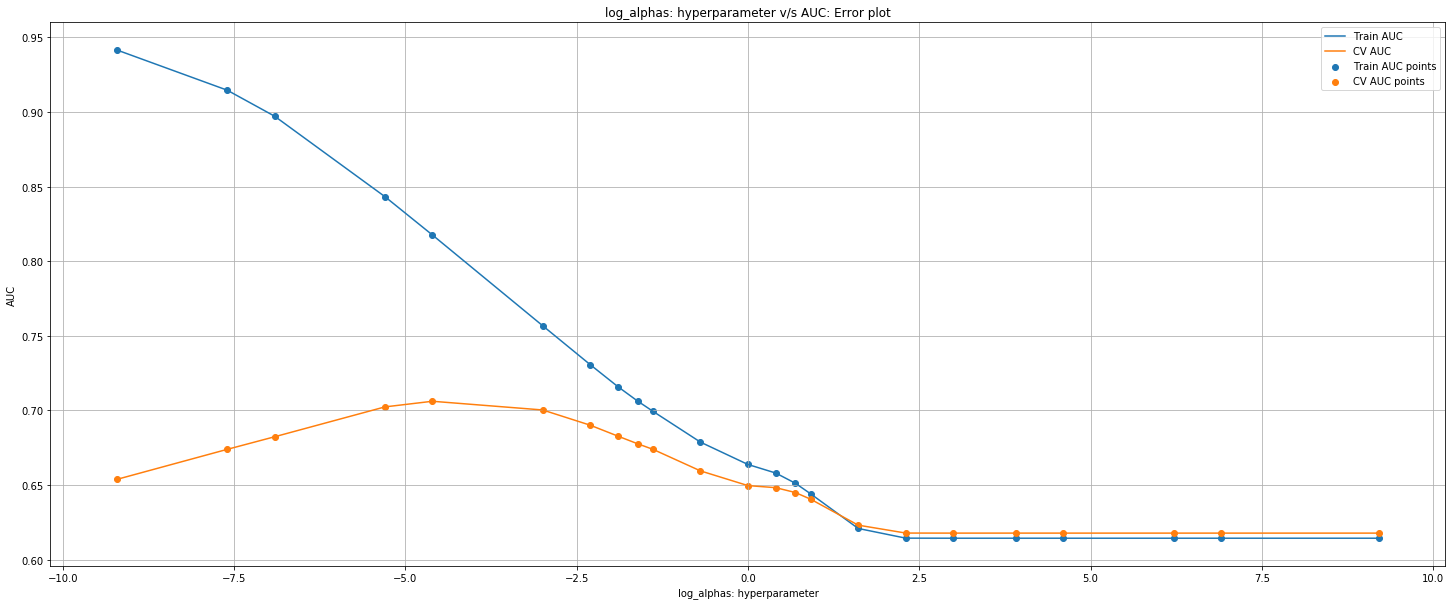

In [64]:
plt.figure(figsize=(25,10))

plt.plot(log_alphas, train_auc, label='Train AUC')
plt.plot(log_alphas, cv_auc, label='CV AUC')

plt.scatter(log_alphas, train_auc, label='Train AUC points')
plt.scatter(log_alphas, cv_auc, label='CV AUC points')

plt.legend()
plt.xlabel("log_alphas: hyperparameter")
plt.ylabel("AUC")
plt.title("log_alphas: hyperparameter v/s AUC: Error plot")
plt.grid()
plt.show()

<h4> With L1 penalty:
<img src = "graphs\bow.PNG">


In [65]:
optimal_alpha = 0.01

<h4> <font color="gray">Training model with optimal value of hyperparameter</font></h4> 

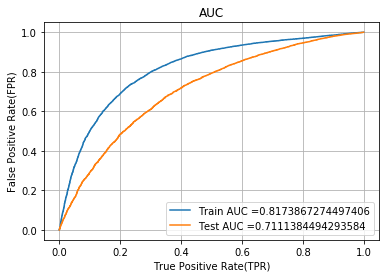

In [66]:
from sklearn.metrics import roc_curve, auc

sgd_bow = SGDClassifier(alpha=0.01, class_weight='balanced', loss='hinge', penalty='l2',max_iter=1000, tol=0.001)
cal_bow = CalibratedClassifierCV(sgd_bow, method='sigmoid', cv=5)
cal_bow.fit(X_train_bow, y_train)
   
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs
y_train_pred = batch_predict(cal_bow, X_train_bow)    
y_test_pred = batch_predict(cal_bow, X_test_bow)


train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

plt.plot(train_fpr, train_tpr, label="Train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="Test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("True Positive Rate(TPR)")
plt.ylabel("False Positive Rate(FPR)")
plt.title("AUC")
plt.grid()
plt.show()

<img src="graphs\aucbow.PNG">

#### NOTE: As per the obeservation, L2 penalty with alpha 0.01 gave better AUC than l1 penalty with alpha 0.0005

<h4> <font color="gray">Getting confusion metrix for both train and test set</font></h4> 

In [67]:
def get_confusion_matrix(clf,X_te,y_te):
    y_pred = clf.predict(X_te) 
    df_cm = pd.DataFrame(confusion_matrix(y_te, y_pred), range(2),range(2))
    df_cm.columns = ['Predicted NO','Predicted YES']
    df_cm = df_cm.rename({0: 'Actual NO', 1: 'Actual YES'})
    sns.set(font_scale=1.4)#for label size
    sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

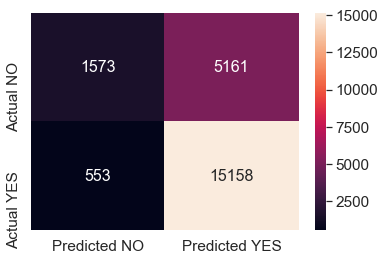

In [68]:
get_confusion_matrix(cal_bow,X_train_bow,y_train)

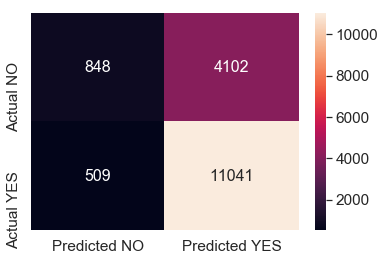

In [69]:
get_confusion_matrix(cal_bow,X_test_bow,y_test)

<h4> <font color="gray">Evaluating model performance</font></h4> 

In [70]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score

y_pred_new = cal_bow.predict(X_test_bow)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred_new)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred_new)))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred_new)))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred_new)))

Accuracy on test set: 72.055%
Precision on test set: 0.729
Recall on test set: 0.956
F1-Score on test set: 0.827


<h3><font color='black'>Set 2: categorical, numerical features + project_title(TFIDF)+  preprocessed_eassay(TFIDF)</font></h3>

<h4> <font color="gray">Hstacking features</font></h4> 

In [71]:
# merge two sparse matrices: https://stackoverflow.com/a/19710648/4084039
from scipy.sparse import hstack
# with the same hstack function we are concatinating a sparse matrix and a dense matirx :)
X_train_tfidf = hstack((X_train_categories_one_hot, X_train_sub_categories_one_hot, X_train_essay_tfidf, quantity_train, X_train_state_one_hot, X_train_prefix_one_hot, X_train_grade_one_hot, X_train_title_tfidf, price_train, number_projects_train)).tocsr()
X_cv_tfidf = hstack((X_cv_categories_one_hot, X_cv_sub_categories_one_hot, X_cv_essay_tfidf, quantity_cv, X_cv_state_one_hot, X_cv_prefix_one_hot, X_cv_grade_one_hot, X_cv_title_tfidf, price_cv, number_projects_cv)).tocsr()
X_test_tfidf = hstack((X_test_categories_one_hot, X_test_sub_categories_one_hot, X_test_essay_tfidf, quantity_test, X_test_state_one_hot, X_test_prefix_one_hot, X_test_grade_one_hot, X_test_title_tfidf, price_test, number_projects_test)).tocsr()

print('Final matrix')
print(X_train_tfidf.shape, y_train.shape)
print(X_cv_tfidf.shape, y_cv.shape)
print(X_test_tfidf.shape, y_test.shape)

Final matrix
(22445, 9975) (22445,)
(11055, 9975) (11055,)
(16500, 9975) (16500,)


<h4> <font color="black">Hyperparameter tuning</font></h4> 

In [72]:
from sklearn.linear_model import SGDClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
import math

train_auc = []
cv_auc = []
log_alphas = []

alphas = [0.0001, 0.0005, 0.001,0.005, 0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.5, 1.0, 1.5, 2.0, 2.5, 5, 10, 20, 50, 100, 500,1000,10000] #Taking random values of alpha

for i in (alphas):
    sgd_tfidf = SGDClassifier(alpha=i, class_weight='balanced', loss='hinge', penalty='l2',tol=0.001)
    cal_tfidf = CalibratedClassifierCV(sgd_tfidf, method='sigmoid', cv='warn')
    cal_tfidf.fit(X_train_tfidf, y_train)
    
    y_train_pred = batch_predict(cal_tfidf, X_train_tfidf )    
    y_cv_pred = batch_predict(cal_tfidf, X_cv_tfidf)
    

    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs        
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))
    
for a in tqdm(alphas):
    b = math.log(a)
    log_alphas.append(b)

100%|██████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<?, ?it/s]


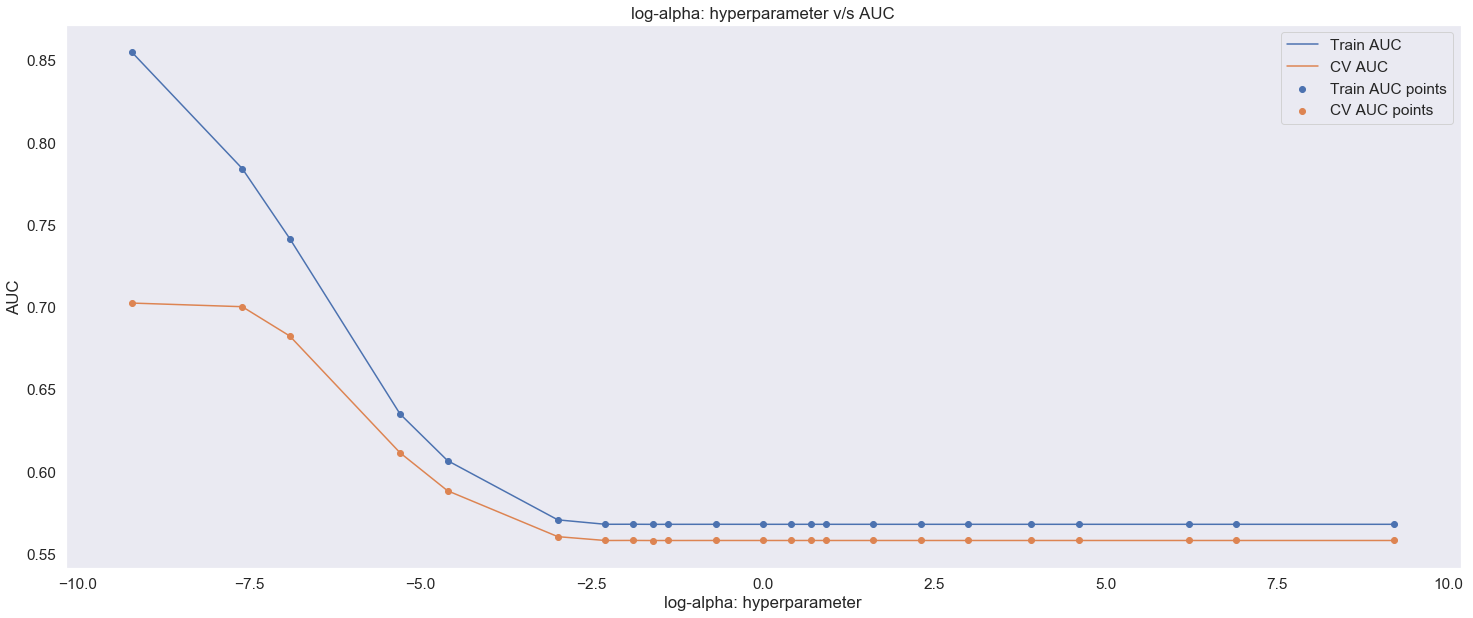

In [73]:
plt.figure(figsize=(25,10))
plt.plot(log_alphas, train_auc, label='Train AUC')
plt.plot(log_alphas, cv_auc, label='CV AUC')

plt.scatter(log_alphas, train_auc, label='Train AUC points')
plt.scatter(log_alphas, cv_auc, label='CV AUC points')

plt.legend()
plt.xlabel("log-alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("log-alpha: hyperparameter v/s AUC")
plt.grid()
plt.show()

<h4> With L1 penalty:
<img src = "graphs\tfidf.PNG">


In [74]:
optimal_alpha  = 0.001

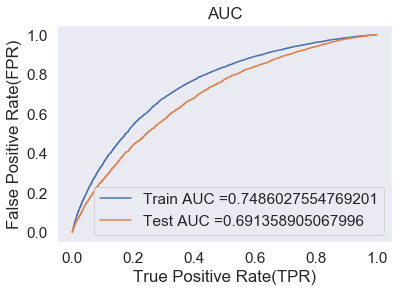

In [75]:
from sklearn.metrics import roc_curve, auc

sgd_tfidf = SGDClassifier(alpha=0.001, class_weight='balanced', loss='hinge', penalty='l2')
    
cal_tfidf = CalibratedClassifierCV(sgd_tfidf, method='sigmoid', cv='warn')
cal_tfidf.fit(X_train_tfidf, y_train)

y_train_pred = batch_predict(cal_tfidf, X_train_tfidf)    
y_test_pred = batch_predict(cal_tfidf, X_test_tfidf)

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

plt.plot(train_fpr, train_tpr, label="Train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="Test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("True Positive Rate(TPR)")
plt.ylabel("False Positive Rate(FPR)")
plt.title("AUC")
plt.grid()
plt.show()

<img src ="graphs\auctfidf.PNG">
NOTE: As per the obeservation, L2 penalty with alpha 0.001 gave better AUC than l1 penalty with alpha 0.0005

<h4> <font color="gray">Confusion matrix</font></h4> 

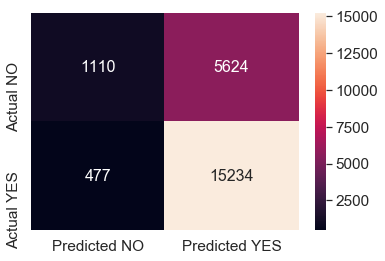

In [76]:
get_confusion_matrix(cal_tfidf,X_train_tfidf,y_train)

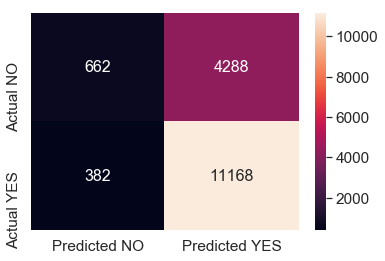

In [77]:
get_confusion_matrix(cal_tfidf,X_test_tfidf,y_test)

<h4> <font color="gray">Evaluating model performance</font></h4> 

In [78]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score

y_pred_new = cal_tfidf.predict(X_test_tfidf)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred_new)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred_new)))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred_new)))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred_new)))

Accuracy on test set: 71.697%
Precision on test set: 0.723
Recall on test set: 0.967
F1-Score on test set: 0.827


<h3><font color='black'>Set 3: categorical, numerical features + project_title(AVG W2V)+  preprocessed_eassay (AVG W2V)</font></h3>

<h4> <font color="gray">Hstacking features</font></h4> 

In [79]:
# merge two sparse matrices: https://stackoverflow.com/a/19710648/4084039
from scipy.sparse import hstack
# with the same hstack function we are concatinating a sparse matrix and a dense matirx :)
X_train_avg = hstack((X_train_categories_one_hot, X_train_sub_categories_one_hot, train_essay_avg_w2v, quantity_train, X_train_state_one_hot, X_train_prefix_one_hot, X_train_grade_one_hot, train_title_avg_w2v, price_train, number_projects_train)).tocsr()
X_cv_avg = hstack((X_cv_categories_one_hot, X_cv_sub_categories_one_hot, cv_essay_avg_w2v, quantity_cv, X_cv_state_one_hot, X_cv_prefix_one_hot, X_cv_grade_one_hot, cv_title_avg_w2v, price_cv, number_projects_cv)).tocsr()
X_test_avg = hstack((X_test_categories_one_hot, X_test_sub_categories_one_hot, test_essay_avg_w2v, quantity_test, X_test_state_one_hot, X_test_prefix_one_hot, X_test_grade_one_hot, test_title_avg_w2v, price_test, number_projects_test)).tocsr()

print('Final matrix')
print(X_train_avg.shape, y_train.shape)
print(X_cv_avg.shape, y_cv.shape)
print(X_test_avg.shape, y_test.shape)

Final matrix
(22445, 702) (22445,)
(11055, 702) (11055,)
(16500, 702) (16500,)


<h4> <font color="gray">Hyperparameter Tuning</font></h4> 

In [80]:
from sklearn.linear_model import SGDClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
import math

train_auc = []
cv_auc = []
log_alphas = []

alphas = [0.0001, 0.0005, 0.001,0.005, 0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.5, 1.0, 1.5, 2.0, 2.5, 5, 10, 20, 50, 100, 500,1000,10000] #Taking random values of alpha

for i in (alphas):
    sgd_avg = SGDClassifier(alpha=i, class_weight='balanced', loss='hinge', penalty='l2')
    cal_avg = CalibratedClassifierCV(sgd_avg, method='sigmoid', cv='warn')
    cal_avg.fit(X_train_avg, y_train)
    

    y_train_pred = batch_predict(cal_avg, X_train_avg )    
    y_cv_pred = batch_predict(cal_avg, X_cv_avg)
    

    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs        
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))
    
for a in (alphas):
    b = math.log(a)
    log_alphas.append(b)

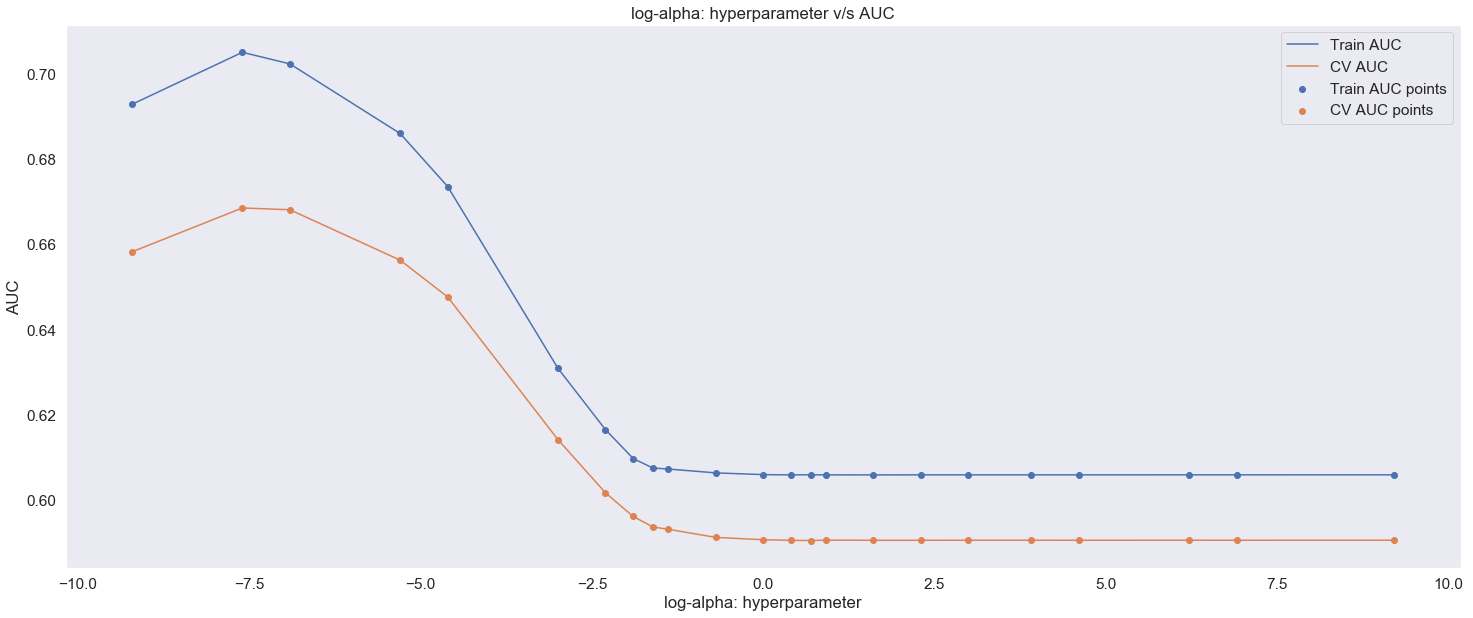

In [81]:
plt.figure(figsize=(25,10))
plt.plot(log_alphas, train_auc, label='Train AUC')
plt.plot(log_alphas, cv_auc, label='CV AUC')

plt.scatter(log_alphas, train_auc, label='Train AUC points')
plt.scatter(log_alphas, cv_auc, label='CV AUC points')

plt.legend()
plt.xlabel("log-alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("log-alpha: hyperparameter v/s AUC")
plt.grid()
plt.show()

<h4> With L1 penalty:
<img src = "graphs\avg.PNG">


In [82]:
optimal_alpha = 0.001

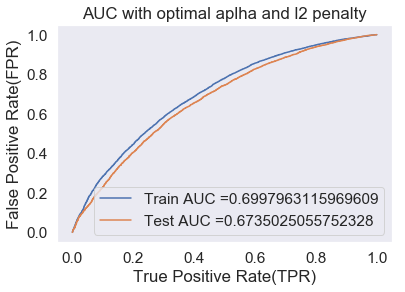

In [83]:
from sklearn.metrics import roc_curve, auc

sgd_avg = SGDClassifier(alpha=0.001, class_weight='balanced', loss='hinge', penalty='l2')
cal_avg = CalibratedClassifierCV(sgd_avg, method='sigmoid', cv='warn')
cal_avg.fit(X_train_avg, y_train)
    
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

y_train_pred = batch_predict(cal_avg, X_train_avg)    
y_test_pred = batch_predict(cal_avg, X_test_avg)

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

plt.plot(train_fpr, train_tpr, label="Train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="Test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("True Positive Rate(TPR)")
plt.ylabel("False Positive Rate(FPR)")
plt.title("AUC with optimal aplha and l2 penalty")
plt.grid()
plt.show()

<img src="graphs\aucavg.PNG">

NOTE: As per the obeservation, L2 penalty with alpha 0.001 give better AUC than l1 penalty with alpha 0.001</font></h4>

<h4> <font color="gray">Confusion matrix</font></h4> 

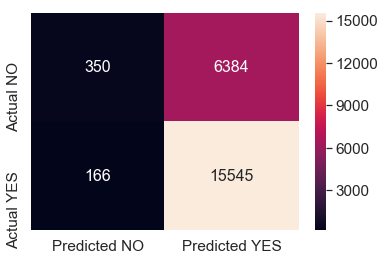

In [84]:
get_confusion_matrix(cal_avg,X_train_avg,y_train)

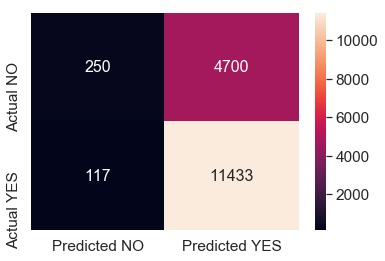

In [85]:
get_confusion_matrix(cal_avg,X_test_avg,y_test)

<h4> <font color="gray">Evaluating model performance</font></h4> 

In [86]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score

y_pred_new = cal_avg.predict(X_test_avg)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred_new)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred_new)))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred_new)))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred_new)))

Accuracy on test set: 70.806%
Precision on test set: 0.709
Recall on test set: 0.990
F1-Score on test set: 0.826


<h3><font color='black'>Set 4: categorical, numerical features + project_title(TFIDF W2V)+  preprocessed_essay (TFIDF W2V)</font></h3>   

<h4> <font color="gray">Hstacking features</font></h4> 

In [87]:
# merge two sparse matrices: https://stackoverflow.com/a/19710648/4084039
from scipy.sparse import hstack
# with the same hstack function we are concatinating a sparse matrix and a dense matirx :)
X_train_tfidf_w2v = hstack((X_train_categories_one_hot, X_train_sub_categories_one_hot, train_essay_tfidf_w2v, quantity_train, X_train_state_one_hot, X_train_prefix_one_hot, X_train_grade_one_hot, train_title_tfidf_w2v, price_train, number_projects_train)).tocsr()
X_cv_tfidf_w2v = hstack((X_cv_categories_one_hot, X_cv_sub_categories_one_hot, cv_essay_tfidf_w2v, quantity_cv, X_cv_state_one_hot, X_cv_prefix_one_hot, X_cv_grade_one_hot, cv_title_tfidf_w2v, price_cv, number_projects_cv)).tocsr()
X_test_tfidf_w2v = hstack((X_test_categories_one_hot, X_test_sub_categories_one_hot, test_essay_tfidf_w2v, quantity_test, X_test_state_one_hot, X_test_prefix_one_hot, X_test_grade_one_hot, test_title_tfidf_w2v, price_test, number_projects_test)).tocsr()

print('Final matrix')
print(X_train_tfidf_w2v.shape, y_train.shape)
print(X_cv_tfidf_w2v.shape, y_cv.shape)
print(X_test_tfidf_w2v.shape, y_test.shape)

Final matrix
(22445, 702) (22445,)
(11055, 702) (11055,)
(16500, 702) (16500,)


<h4> <font color="gray">Hyperparameter tuning</font></h4> 

In [88]:
from sklearn.linear_model import SGDClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
import math

train_auc = []
cv_auc = []
log_alphas = []

alphas = [0.0001, 0.0005, 0.001,0.005, 0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.5, 1.0, 1.5, 2.0, 2.5, 5, 10, 20, 50, 100, 500,1000,10000]   #Taking random values of alpha

for i in tqdm(alphas):
    sgd_tfidf_w2v = SGDClassifier(alpha=i, class_weight='balanced', loss='hinge', penalty='l2')
    cal_tfidf_w2v = CalibratedClassifierCV(sgd_tfidf_w2v, method='sigmoid', cv='warn')
    cal_tfidf_w2v.fit(X_train_tfidf_w2v, y_train)
    
    y_train_pred = batch_predict(cal_tfidf_w2v, X_train_tfidf_w2v )    
    y_cv_pred = batch_predict(cal_tfidf_w2v, X_cv_tfidf_w2v)
    

    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs        
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))
    
for a in tqdm(alphas):
    b = math.log(a)
    log_alphas.append(b)

100%|██████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<?, ?it/s]


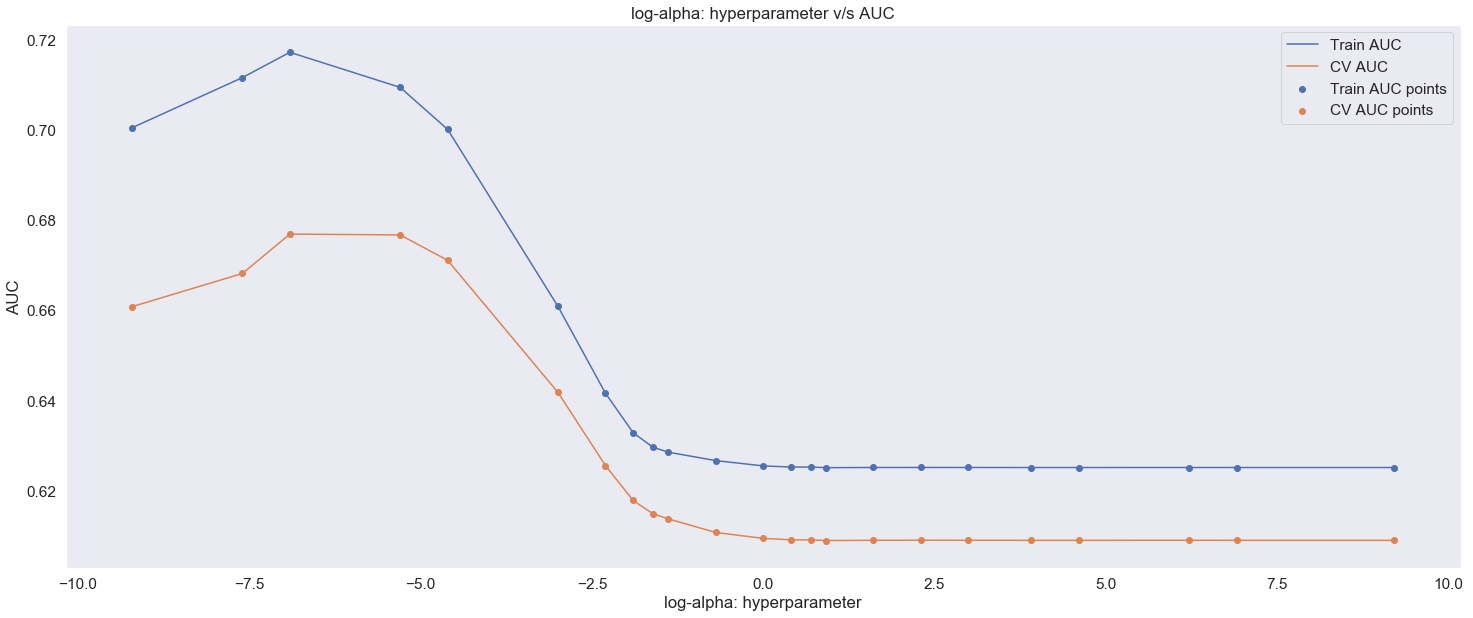

In [89]:
plt.figure(figsize=(25,10))
plt.plot(log_alphas, train_auc, label='Train AUC')
plt.plot(log_alphas, cv_auc, label='CV AUC')

plt.scatter(log_alphas, train_auc, label='Train AUC points')
plt.scatter(log_alphas, cv_auc, label='CV AUC points')

plt.legend()
plt.xlabel("log-alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("log-alpha: hyperparameter v/s AUC")
plt.grid()
plt.show()

<h4> With L1 penalty:
<img src = "graphs\tfidfwv.PNG">


In [90]:
optimal_alpha = 0.001

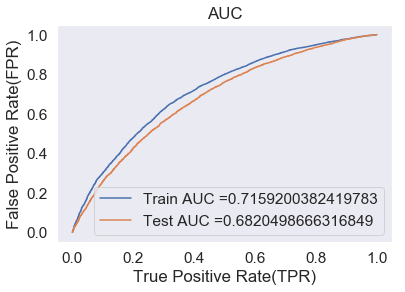

In [91]:
from sklearn.metrics import roc_curve, auc

sgd_tfidf_w2v = SGDClassifier(alpha=0.001, class_weight='balanced', loss='hinge', penalty='l2')
cal_tfidf_w2v = CalibratedClassifierCV(sgd_tfidf_w2v, method='sigmoid', cv='warn')
cal_tfidf_w2v.fit(X_train_tfidf_w2v, y_train)
    
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

y_train_pred = batch_predict(cal_tfidf_w2v, X_train_tfidf_w2v)    
y_test_pred = batch_predict(cal_tfidf_w2v, X_test_tfidf_w2v)

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

plt.plot(train_fpr, train_tpr, label="Train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="Test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("True Positive Rate(TPR)")
plt.ylabel("False Positive Rate(FPR)")
plt.title("AUC")
plt.grid()
plt.show()

<img src="graphs\auctfwv.PNG">

NOTE: As per the obeservation, L2 penalty with alpha 0.001 give better AUC than l1 penalty with alpha 0.001</font></h4>

<h4> <font color="gray">Confusion matrix</font></h4> 

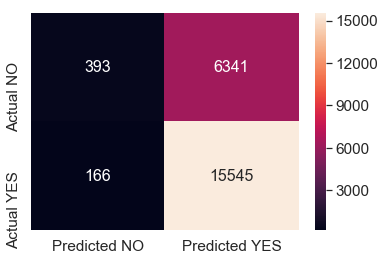

In [92]:
get_confusion_matrix(cal_tfidf_w2v,X_train_tfidf_w2v,y_train)

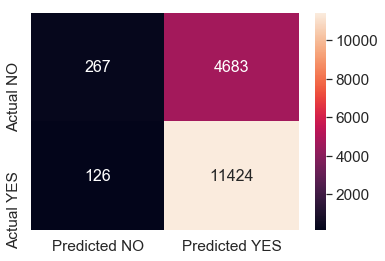

In [93]:
get_confusion_matrix(cal_tfidf_w2v,X_test_tfidf_w2v,y_test)

<h4> <font color="gray">Evaluating Model performance</font></h4> 

In [94]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score

y_pred_new = cal_tfidf_w2v.predict(X_test_tfidf_w2v)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred_new)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred_new)))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred_new)))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred_new)))

Accuracy on test set: 70.855%
Precision on test set: 0.709
Recall on test set: 0.989
F1-Score on test set: 0.826


<h3><font color='black'>Set 5: categorical, numerical features + Sentiment score + Number of words in title and combined essay+ TruncatedSVD on Essay tfidf</font></h3>   

In [95]:
from sklearn.feature_extraction.text import TfidfVectorizer


vectorizer_tfidf_essay = TfidfVectorizer(min_df=10, max_features=3000)
vectorizer_tfidf_essay.fit(X_train['clean_essays'].values)

X_train = vectorizer_tfidf_essay.transform(X_train['clean_essays'])
X_cv = vectorizer_tfidf_essay.transform(X_cv['clean_essays'])
X_test = vectorizer_tfidf_essay.transform(X_test['clean_essays'])

print("After vectorizing")
print(X_train.shape, y_train.shape)
print(X_cv.shape, y_cv.shape)
print(X_test.shape, y_test.shape)

After vectorizing
(22445, 3000) (22445,)
(11055, 3000) (11055,)
(16500, 3000) (16500,)


In [96]:
X_train.tocsr()

<22445x3000 sparse matrix of type '<class 'numpy.float64'>'
	with 2043378 stored elements in Compressed Sparse Row format>

In [97]:
type(X_train)

scipy.sparse.csr.csr_matrix

<h4> <font color="gray">Hstacking features</font></h4> 

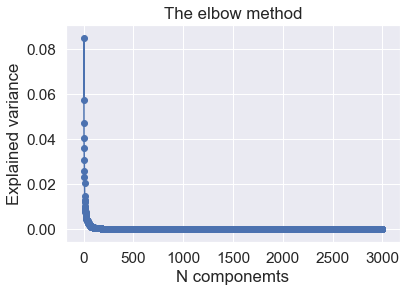

In [98]:
#https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html
#https://chrisalbon.com/machine_learning/feature_engineering/select_best_number_of_components_in_tsvd/
from sklearn.decomposition import TruncatedSVD
n_comp = list(range(1,3000))

tsvd = TruncatedSVD(n_components=2999, algorithm='randomized', n_iter=5, random_state=None, tol=0.001)
tsvd.fit(X_train_tfidf)
tsvd_var_ratio = tsvd.explained_variance_ratio_

tsvd_var_ratio = tsvd_var_ratio.tolist()
plt.plot(n_comp,tsvd_var_ratio, label='N component plot')
plt.scatter(n_comp,tsvd_var_ratio, label='N component points')
plt.title("The elbow method")
plt.xlabel("N componemts")
plt.ylabel("Explained variance")
plt.show()

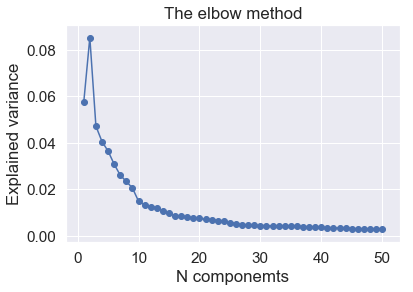

In [99]:
#Plotting for n components 0-50
plt.plot(n_comp[0:50],tsvd_var_ratio[0:50], label='N component plot')
plt.scatter(n_comp[0:50],tsvd_var_ratio[0:50], label='N component points')
plt.title("The elbow method")
plt.xlabel("N componemts")
plt.ylabel("Explained variance")
plt.show()

In [100]:
tsvd = TruncatedSVD(n_components=10, algorithm='randomized', n_iter=5, random_state=None,tol=0.001)
tsvd.fit(X_train)
tsvd_train = tsvd.transform(X_train)
tsvd_test = tsvd.transform(X_test)
tsvd_cv = tsvd.transform(X_cv)

In [101]:
# merge two sparse matrices: https://stackoverflow.com/a/19710648/4084039
from scipy.sparse import hstack
# with the same hstack function we are concatinating a sparse matrix and a dense matirx :)
X_train = hstack((X_train_categories_one_hot, X_train_sub_categories_one_hot,quantity_train, X_train_state_one_hot, X_train_prefix_one_hot, X_train_grade_one_hot, price_train, number_projects_train,essay_size_train,title_size_train,essay_sentiment_train,tsvd_train)).tocsr()
X_cv = hstack((X_cv_categories_one_hot, X_cv_sub_categories_one_hot, quantity_cv, X_cv_state_one_hot, X_cv_prefix_one_hot, X_cv_grade_one_hot, price_cv, number_projects_cv,essay_size_cv,title_size_cv,essay_sentiment_cv,tsvd_cv)).tocsr()
X_test = hstack((X_test_categories_one_hot, X_test_sub_categories_one_hot,quantity_test, X_test_state_one_hot, X_test_prefix_one_hot, X_test_grade_one_hot,price_test, number_projects_test,essay_size_test,title_size_test,essay_sentiment_test,tsvd_test)).tocsr()

print('Final matrix')
print(X_train.shape, y_train.shape)
print(X_cv.shape, y_cv.shape)
print(X_test.shape, y_test.shape)

Final matrix
(22445, 115) (22445,)
(11055, 115) (11055,)
(16500, 115) (16500,)


<h4> <font color="gray">Hyperparameter tuning</font></h4> 

In [134]:
from sklearn.linear_model import SGDClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
import math

train_auc = []
cv_auc = []
log_alphas = []

alphas = [0.0001, 0.0005, 0.001,0.005, 0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.5, 1.0, 1.5, 2.0, 2.5, 5, 10, 20, 50, 100, 500,1000,10000] #Taking random values of alpha

for i in (alphas):
    sgd_tfidf = SGDClassifier(alpha=i, loss='hinge', penalty='l1',tol=0.001, class_weight='balanced')
    cal_tfidf = CalibratedClassifierCV(sgd_tfidf, method='sigmoid', cv='warn')
    cal_tfidf.fit(X_train, y_train)
    
    y_train_pred = batch_predict(cal_tfidf, X_train)    
    y_cv_pred = batch_predict(cal_tfidf, X_cv)
    

    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs        
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))
    
for a in tqdm(alphas):
    b = math.log(a)
    log_alphas.append(b)

100%|██████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<?, ?it/s]


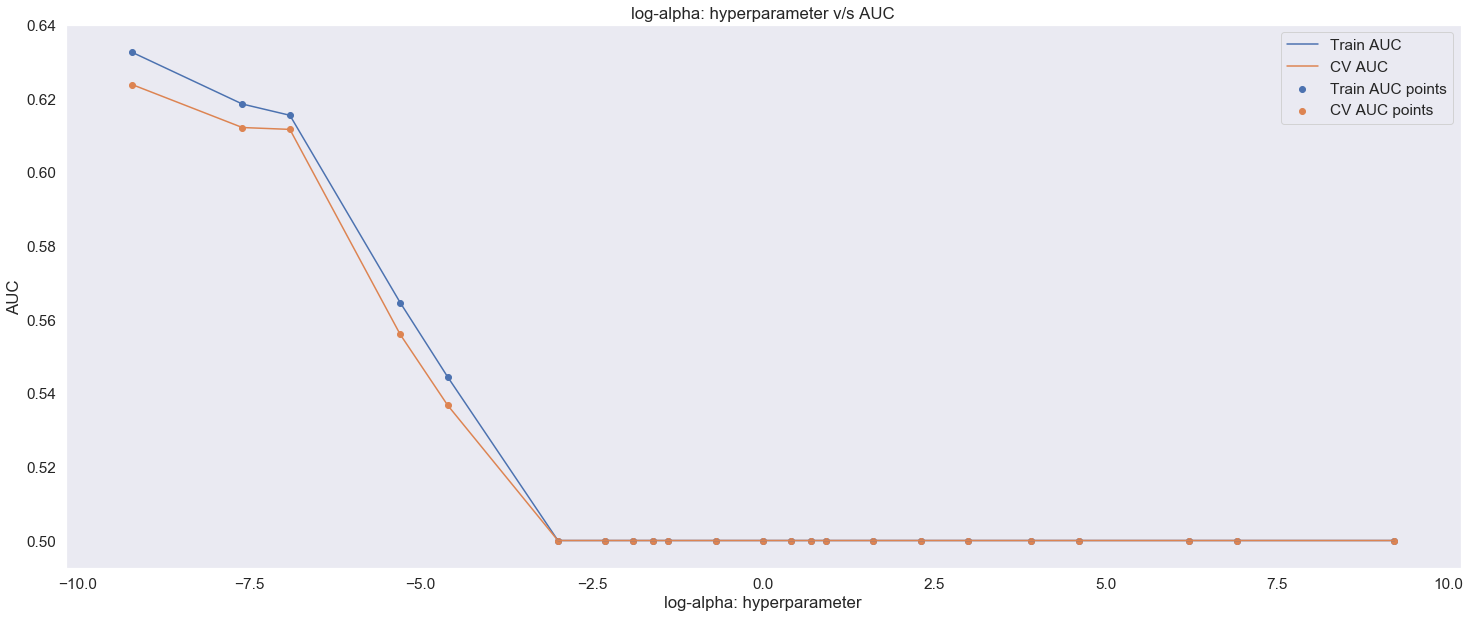

In [135]:
plt.figure(figsize=(25,10))
plt.plot(log_alphas, train_auc, label='Train AUC')
plt.plot(log_alphas, cv_auc, label='CV AUC')

plt.scatter(log_alphas, train_auc, label='Train AUC points')
plt.scatter(log_alphas, cv_auc, label='CV AUC points')

plt.legend()
plt.xlabel("log-alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("log-alpha: hyperparameter v/s AUC")
plt.grid()
plt.show()

In [136]:
optimal_alpha = 0.0001

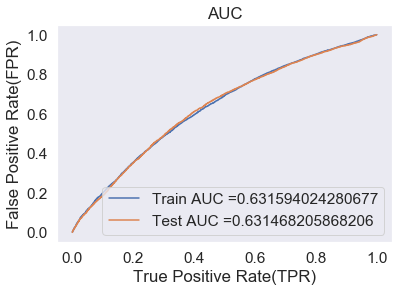

In [147]:

from sklearn.metrics import roc_curve, auc

sgd_tfidf = SGDClassifier(alpha=0.0001, loss='hinge', penalty='l1',tol=0.001)
cal_tfidf = CalibratedClassifierCV(sgd_tfidf, method='sigmoid', cv='warn')
cal_tfidf.fit(X_train, y_train)
    
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

y_train_pred = batch_predict(cal_tfidf, X_train)    
y_test_pred = batch_predict(cal_tfidf, X_test)

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

plt.plot(train_fpr, train_tpr, label="Train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="Test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("True Positive Rate(TPR)")
plt.ylabel("False Positive Rate(FPR)")
plt.title("AUC")
plt.grid()
plt.show()

<h4><font color="gray"> Confusion matrix</font></h4>

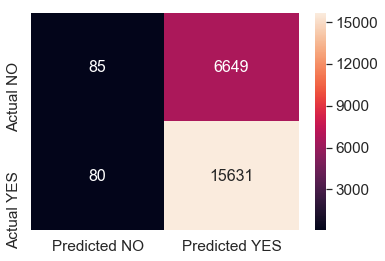

In [148]:
get_confusion_matrix(cal_tfidf,X_train,y_train)

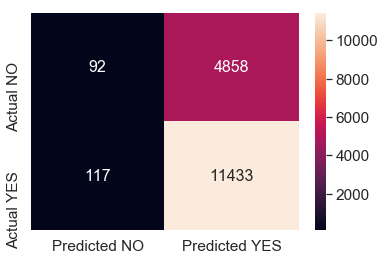

In [149]:
get_confusion_matrix(cal_tfidf,X_test,y_test)

<h4> <font color="gray">Evaluating Model performance</font></h4> 

In [150]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score

y_pred_new = cal_tfidf.predict(X_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred_new)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred_new)))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred_new)))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred_new)))

Accuracy on test set: 69.848%
Precision on test set: 0.702
Recall on test set: 0.990
F1-Score on test set: 0.821


In [151]:
from prettytable import PrettyTable
    
x = PrettyTable()

x.field_names = ["Vectorizer", "Hyperparameter","Penalty", "Train AUC","Test AUC","F1 Score","Accuracy on test set"]

x.add_row(["BoW (set 1)",0.01,"l2", 0.81, 0.71,0.827,"72.055%"])
x.add_row(["TFIDF (set 2)",0.001,"l2", 0.74, 0.69,0.827,"71.697%"])
x.add_row(["AVG W2V (set 3)",0.001,"l2", 0.69, 0.67,0.826,"70.806%"])
x.add_row(["TFIDF W2V (set 4)",0.001,"l2", 0.71, 0.68, 0.826,"70.855%"])
x.add_row(["TFIDF TruncatedSVD",0.0001,"l2", 0.63, 0.63,0.821,"69.848%"])

print(x)

+--------------------+----------------+---------+-----------+----------+----------+----------------------+
|     Vectorizer     | Hyperparameter | Penalty | Train AUC | Test AUC | F1 Score | Accuracy on test set |
+--------------------+----------------+---------+-----------+----------+----------+----------------------+
|    BoW (set 1)     |      0.01      |    l2   |    0.81   |   0.71   |  0.827   |       72.055%        |
|   TFIDF (set 2)    |     0.001      |    l2   |    0.74   |   0.69   |  0.827   |       71.697%        |
|  AVG W2V (set 3)   |     0.001      |    l2   |    0.69   |   0.67   |  0.826   |       70.806%        |
| TFIDF W2V (set 4)  |     0.001      |    l2   |    0.71   |   0.68   |  0.826   |       70.855%        |
| TFIDF TruncatedSVD |     0.0001     |    l2   |    0.63   |   0.63   |  0.821   |       69.848%        |
+--------------------+----------------+---------+-----------+----------+----------+----------------------+


### Conclusion:
 1. L2 penalty gave better AUC scores than L1 penalty.
 2. All the model has more than 84% accuracy on test set.
 3. BoW and Tfidf W2V model has performed slightly better than other models.
 4. Linear SVM has performed better than any other models so far.
 5. Slight decrease in accuracy has been obeserved in the model 5.
